In [7]:
import sys
sys.path.append('../')
import karman
import pandas as pd
import torch
import datetime
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

torch.set_default_dtype(torch.float32)


In [8]:
#input features to the model
num_features=18

In [9]:
karman_model = karman.density_models.load_model(
                                        num_instantaneous_features=num_features,
                                        model_path='../models/karman_nowcast_model_log_exp_residual_valid_mape_15.14_params_35585.torch',
                                        device="cpu",
                                        prediction_type="nowcasting",
                                        hidden_layer_dims=128,
                                        hidden_layers=3
                                        )
karman_model.eval()

number of parmaeters: 35585


/home/ga00693/karman/notebooks/../karman/density_models.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  karman_model.load_state_dict(torch.load(model_path))


SimpleNetwork(
  (dropout): Dropout(p=0.0, inplace=False)
  (fcs): ModuleList(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1-2): 2 x Linear(in_features=128, out_features=128, bias=True)
  )
  (act): LeakyReLU(negative_slope=0.01)
  (acts): ModuleList(
    (0-2): 3 x LeakyReLU(negative_slope=0.01)
  )
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
)

In [10]:
with open("normalization_dict.pk","rb") as f:
    normalization_dict=pk.load(f)

In [11]:
n_grid=100
u, v = np.linspace(0, 1, n_grid), np.linspace(0, 1, n_grid)
longitude, latitude = np.sort(2 * np.pi * u), np.sort(np.arccos(2 * v - 1) - np.pi / 2)
lonlat_grid = np.stack([*np.meshgrid(longitude, latitude, indexing="ij")], axis=2).reshape(-1, 2) 
lonlat_grid[:,0]-=np.pi

In [12]:
#let's prepare the inputs to the model and run it:
longitudes=list(np.rad2deg(lonlat_grid[:,0],dtype=np.float32))
latitudes=list(np.rad2deg(lonlat_grid[:,1],dtype=np.float32))
n_samples=len(longitudes)
altitudes=[450000.]*n_samples#250km in meters
dates=['2022-05-08 00:59:47']*n_samples

In [13]:
density_nn = karman.density_models.nowcasting_model(dates=dates,
                                                    altitudes=altitudes,
                                                    longitudes=longitudes,
                                                    latitudes=latitudes,
                                                    karman_model=karman_model,
                                                    device=torch.device('cpu'))


In [14]:
#let's extract the SW inputs to compute NRLMSISE-00:
sw_df=karman.util.find_sw_from_thermo(pd.to_datetime(dates),karman.density_models.df_sw)
ap=sw_df['celestrack__ap_average__'].values
f107=sw_df['space_environment_technologies__f107_obs__'].values
f107A=sw_df['space_environment_technologies__f107_average__'].values

In [15]:
from nrlmsise00 import msise_flat
d=pd.to_datetime(dates)
density_nrlmsise00=msise_flat(d.to_pydatetime(), altitudes, latitudes, longitudes, f107A, f107, ap)[:,5]*1e3


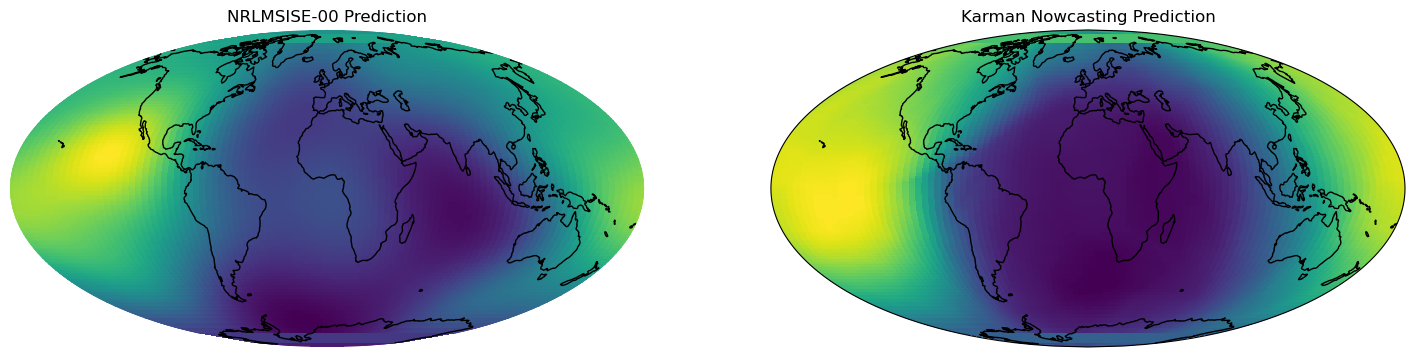

In [16]:
# we setup the longitude x latitude grid, and compute the relative error (in %)
lon_grid = np.rad2deg(lonlat_grid[:, 0].reshape((n_grid, n_grid)))
lat_grid = np.rad2deg(lonlat_grid[:, 1].reshape((n_grid, n_grid)))
#rel_err = ((density_nrlmsise00 - density_nn) / density_nn) * 100
# we print to scree the mean absolute percentage error on the globe map:
#print(
#    f"Average absolute relative percentage error on globe map: {abs(rel_err).mean()} %"
#)

# we now create a figure with a globe projection on top:
fig, ax = plt.subplots(
    figsize=(18, 12),
    nrows=1,
    ncols=2,
    subplot_kw={"projection": ccrs.Mollweide(central_longitude=0)},
)
# we flatten the axis and remove the last figure
#ax = ax.ravel()
ax[0].axis("off")

# we plot NRLMSISE-00 on the first figure:
ax[0].pcolormesh(
    lon_grid,
    lat_grid,
    density_nrlmsise00.reshape((n_grid, n_grid)),
    transform=ccrs.PlateCarree(),
    vmin=min(density_nrlmsise00),
    vmax=max(density_nrlmsise00),
)
ax[0].set_global()
ax[0].coastlines()
# ax[0].gridlines()
ax[0].set_title("NRLMSISE-00 Prediction")

# the NN prediction on the second:
im2 = ax[1].pcolormesh(
    lon_grid,
    lat_grid,
    density_nn.reshape((n_grid, n_grid)),
    transform=ccrs.PlateCarree(),
    vmin=min(density_nn),
    vmax=max(density_nn),
)
ax[1].set_global()
ax[1].coastlines()
# ax[1].gridlines()
ax[1].set_title("Karman Nowcasting Prediction")
plt.show()